# What will we do here?

We are going to implement a method of Khmer word segmentation and Part-Of-Speech(POS) tagging introduced in a paper entitled ```Joint Khmer Word Segmentation and Part-of-Speech Tagging Using Deep Learning```[1].

## Overview

- Task: Joint word segmentation and POS tagging
  - word segmentation: break a sentence into list of words
  - POS tagging: labelling part-of-speech to each word

- Why this task?
  - Computers do not understand our language!
  - Want to encode our language (syntactically, semantically) which can work with Computer!
  - Word is the most fundamental element to understand language (meaning)
  - So, need word segmentation process!!!
  - Part-of-speech helps in further understanding!!!
  - These tasks strongly effect other Natural Language Processing tasks (Machine Translation, Speech recognition...)


- Problem: where to seperate words in a sentence? What is the part-of-speech of those words?
  - In English, easily choose **white space** as a symbol of word seperation.
  - How about **Khmer**? →　No IDEA ???

- What people did to solve this/these task(s)?
  - In general, people solve these tasks seperately
  - Manually (human)
  - Conditional Random Field
  - Deep Learning: RNN, LSTM, etc.

- And what is introduced in [1] ?
  - Use Deep Learning approach
    - Bi-directional Long Short-Term Memory (BiLSTM)
  - Use character level input
  - Jointly predict where to seperate words and their pos at the same time
  - Read the [paper](https://arxiv.org/abs/2103.16801) for detail!!!


# Code

## Data


In [1]:
from utils import Tokenizer, khPOSdataset, DataLoader

### Data preprocessing

In [2]:
tokenizer = Tokenizer('/content/train.all.txt')

In [3]:
print(tokenizer.posDict)
print(tokenizer.chDict)
print(len(tokenizer.train_data))

{'IN': 1, 'DT': 2, 'NN': 3, 'AUX': 4, 'VB': 5, 'RB': 6, 'JJ': 7, 'SYM': 8, 'CD': 9, 'PN': 10, 'PRO': 11, 'CC': 12, 'PA': 13, 'QT': 14, 'AB': 15, 'NS': 16, '<PAD>': 0}
{'ក': 1, '្': 2, 'រ': 3, 'ៅ': 4, '_': 5, 'ព': 6, 'ី': 7, 'ន': 8, 'ោ': 9, 'ះ': 10, 'ល': 11, 'ិ': 12, 'ខ': 13, 'ត': 14, 'េ': 15, 'ប': 16, 'ា': 17, 'ញ': 18, 'ជ': 19, '់': 20, 'យ': 21, '៉': 22, 'ង': 23, 'ម': 24, 'អ': 25, '~': 26, 'ឧ': 27, 'ថ': 28, 'ភ': 29, 'ផ': 30, 'ស': 31, 'ៗ': 32, 'ួ': 33, 'ុ': 34, '២': 35, '៥': 36, 'ៀ': 37, 'ទ': 38, '។': 39, 'ំ': 40, 'វ': 41, 'ណ': 42, 'ូ': 43, 'ែ': 44, 'ឈ': 45, 'គ': 46, '័': 47, 'ដ': 48, 'ឯ': 49, 'ធ': 50, 'ឺ': 51, 'ឡ': 52, 'ើ': 53, 'ៃ': 54, '១': 55, 'ច': 56, '៊': 57, 'ឹ': 58, 'ឆ': 59, '៖': 60, '«': 61, 'ហ': 62, 'ឃ': 63, '៧': 64, '៍': 65, '(': 66, ')': 67, 'ឌ': 68, 'ឲ': 69, '^': 70, 'ៈ': 71, 'ឋ': 72, '០': 73, '៤': 74, '៣': 75, 'ឿ': 76, 'ឱ': 77, '»': 78, ',': 79, 'ឍ': 80, '៏': 81, 'ឥ': 82, '“': 83, '”': 84, '.': 85, 'ឬ': 86, '៩': 87, '៨': 88, '៦': 89, '៌': 90, '៕': 91, 'ឮ': 92, 'ឳ': 93, '[':

In [4]:
train_sentences = tokenizer.train_data
close_test_sentences = tokenizer.process_data('/content/CLOST-TEST.txt', 'test')
open_test_sentences = tokenizer.process_data('/content/OPEN-TEST.txt', 'test')

In [5]:
len(train_sentences[0]), len(train_sentences[1]), len(close_test_sentences[0]), len(close_test_sentences[1]), len(open_test_sentences[0]), len(open_test_sentences[1])

(12000, 12000, 1000, 1000, 1000, 1000)

### Prepare Dataset and DataLoader

In [6]:
train_id_sequences = [tokenizer.encode(s, 'ch') for s in  train_sentences[0]]
train_id_labels = [tokenizer.encode(s, 'pos') for s in train_sentences[1]]
close_test_id_sequences = [tokenizer.encode(s, 'ch') for s in  close_test_sentences[0]]
close_test_id_labels = [tokenizer.encode(s, 'pos') for s in close_test_sentences[1]]
open_test_id_sequences = [tokenizer.encode(s, 'ch') for s in  open_test_sentences[0]]
open_test_id_labels = [tokenizer.encode(s, 'pos') for s in open_test_sentences[1]]

train_dataset = khPOSdataset(train_id_sequences, train_id_labels)
close_test_dataset = khPOSdataset(close_test_id_sequences, close_test_id_labels)
open_test_dataset = khPOSdataset(open_test_id_sequences, open_test_id_labels)

## Model

In [7]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [8]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, padding_idx):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, (hidden, cell) = self.lstm(embeds)
        prediction = self.hidden2tag(lstm_out)
        return prediction

## Train and Test

In [9]:
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, batch_first=True, device='cuda', random_state=123)
close_test_loader = DataLoader(close_test_dataset, batch_size=1, shuffle=True, batch_first=True, device='cuda', random_state=123)
open_test_loader = DataLoader(open_test_dataset, batch_size=1, shuffle=True, batch_first=True, device='cuda', random_state=123)

In [10]:
from collections import defaultdict

In [27]:
def evaluate(model, test_loader, verbose=False):
  total_seg, correct_seg = 0, 0
  total_pos = defaultdict(int)
  correct_pos = defaultdict(int)

  model.eval()
  for idx, (inputs, targets) in enumerate(test_loader):
    with torch.no_grad():
      predictions = model(inputs)
      predictions = torch.argmax(torch.softmax(predictions, dim=-1), dim=-1)

      words_seg_, pos_ = tokenizer.decode(targets.cpu().numpy()[0],
                                         inputs.cpu().numpy()[0])
      words_seg_pred, pos_pred = tokenizer.decode(predictions.cpu().numpy()[0],
                                                        inputs.cpu().numpy()[0])

      words_result = [i+'/'+j for (i,j) in zip(words_seg_,pos_) if '<PAD>' not in i]
      words_result_pred = [i+'/'+j for (i,j) in zip(words_seg_pred,pos_pred) if '<PAD>' not in i]

      if verbose:
        all_check = all([i==j for i,j in zip(words_result, words_result_pred)])
        if not all_check:
          print("\nMISTAKE")
          print(f"_human_: {' '.join(words_result)}")
          print(f"system_: {' '.join(words_result_pred)}")
          print("=====================\n")

      total_seg += len(words_seg_)
      for j in words_seg_pred:
        correct_seg += 1 if j in words_seg_ else 0
          
      for j in (words_result):
        total_pos[j.split('/')[1]] += 1
        for k in (words_result_pred):
          if j==k:
            w,p = j.split('/')
            correct_pos[p] += 1
            break
      

  seg_acc = correct_seg/total_seg
  pos_acc = {}
  all_pos_correct, all_pos_total = 0, 0
  for t_p, t_n in total_pos.items():
    pos_acc[t_p] = correct_pos[t_p]/t_n
    all_pos_correct += correct_pos[t_p]
    all_pos_total += t_n
  pos_acc['OVERALL'] = all_pos_correct/all_pos_total

  

  return (seg_acc, pos_acc, correct_seg, total_seg)

In [12]:
import torch
from tqdm import notebook

INPUT_DIM = len(tokenizer.chDict)
OUTPUT_DIM = len(tokenizer.posDict)

PADDING_IDX = tokenizer.chDict['<PAD>']
POS_PADDING_IDX = tokenizer.posDict['<PAD>']

EMBEDDING_DIM = 132
HIDDEN_DIM = 100

EPOCHS = 100

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, INPUT_DIM, OUTPUT_DIM, PADDING_IDX)

loss_function = nn.CrossEntropyLoss(ignore_index=POS_PADDING_IDX)
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

loss_function = loss_function.to(device)
model = model.to(device)

hist = {'loss':[], 'acc':{}}

for epoch in notebook.tqdm(range(EPOCHS)):  
    train_loss = 0.
    model.train()
    for sentence_in, targets in train_loader:
        model.zero_grad()

        sentence_in.to(device)
        targets.to(device)
        
        predictions = model(sentence_in)
        predictions = predictions.view(-1, predictions.shape[-1])
        targets = targets.view(-1)

        loss = loss_function(predictions, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    hist['loss'].append(train_loss)
    
    print("\nepoch{:3} : loss = {:.3f}".format(epoch, train_loss))
    
    model.eval()
    for idx, (inputs, targets) in enumerate(close_test_loader):
      predictions = model(inputs)
      predictions = torch.argmax(torch.softmax(predictions, dim=-1), dim=-1)

      words_seg, pos_ = tokenizer.decode(targets.cpu().numpy()[0], 
                                         inputs.cpu().numpy()[0])
      words_seg_pred, pos_pred = tokenizer.decode(predictions.cpu().numpy()[0],
                                         inputs.cpu().numpy()[0])
      words_result = [i+'/'+j for (i,j) in zip(words_seg,pos_) if '<PAD>' not in i]
      words_result_pred = [i+'/'+j for (i,j) in zip(words_seg_pred,pos_pred) if '<PAD>' not in i]
      print("\n_Human_:",end="")
      print(' '.join(words_result))
      print()
      print("\nMachine:",end="")
      print(' '.join(words_result_pred))

      if idx > 5 : 
        break

Using cuda



epoch  0 : loss = 0.977

_Human_:ខ្ញុំ/PRO ឈ្មោះ/NN អឿង/PN សៅ/PN យឿន/PN


Machine:ខ្ញុំ/PRO ឈ្មោះ/NN អឿង/PN សៅយឿន/PN

_Human_:កញ្ញា/PRO ម៉ែន/PN


Machine:កញ្ញាម៉ែន/PRO

_Human_:លោក~ជំទាវ/PRO អ៊ីម/PN


Machine:លោក~ជំទាវ/PRO អ៊ីម/PN

_Human_:លោក/PRO តាំង/PN


Machine:លោកតាំង/PRO

_Human_:ខ្ញុំ/PRO ឈ្មោះ/NN ភោគ/PN


Machine:ខ្ញុំ/PRO ឈ្មោះភោគ/NN

_Human_:ឯ/IN ម្ចាស់/NN តាំងយូ/NN ឆ្លើយ/VB ថា/IN “/SYM របស់/NN ខ្ញុំ/PRO ៗ/SYM កាន់/VB ដើរ/VB មក/IN ពី/IN ផ្ទះ/NN ចៅ/NN នេះ/DT ដើរ/VB មក/IN ជួប/VB នឹង/IN ខ្ញុំ/PRO បាន/AUX សុំ/VB ដើរ/VB ដោយសារ/VB ម្លប់/NN តាំងយូ/NN ខ្ញុំ/PRO ហើយ/RB យក/VB តាំងយូ/NN ពី/IN ខ្ញុំ/PRO ទៅ/IN កាន់/VB លុះ/IN ដល់/VB ផ្លូវ/NN បែក/JJ មុន_នឹង/IN ដើរ/VB បែក/VB ចេញ/PA ពី/IN គ្នា/PRO ខ្ញុំ/PRO យក/VB តាំងយូ/NN ខ្ញុំ/PRO វិញ/RB ចៅ/NN នេះ/DT ពុំ/RB ឲ្យ/VB ខ្ញុំ/PRO ឡើយ/PA ទើប/RB ខ្ញុំ/PRO ទាំង/DT ២/CD នាំ_គ្នា/RB មក/VB ប្ដឹង/VB លោក~ម្ចាស់/PRO សូម/VB លោក/PRO ពិចារណា/VB ក្ដី/NN នេះ/DT ឲ្យ/IN យើង_ខ្ញុំ/PRO ហោង/PA ”/SYM


Machine:ឯម្ចាស់តាំង/PRO យូឆ្លើយ/NN ថា“របស់/NN ខ្ញុំៗ/NN កាន់/NN

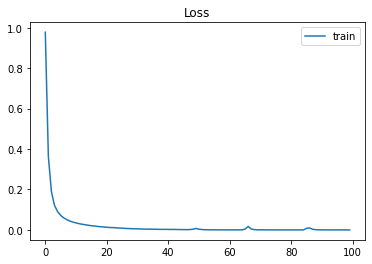

In [13]:
import matplotlib.pyplot as plt

plt.plot([l for l in hist['loss']], label='train')
plt.title('Loss')
plt.legend()
plt.show()

In [14]:
torch.save(model.state_dict(), 'model.pth')
model2 = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, INPUT_DIM, OUTPUT_DIM, PADDING_IDX)
model2.load_state_dict(torch.load('model.pth'))
model2.eval()

LSTMTagger(
  (word_embeddings): Embedding(125, 132, padding_idx=0)
  (lstm): LSTM(132, 100, num_layers=2, batch_first=True, bidirectional=True)
  (hidden2tag): Linear(in_features=200, out_features=17, bias=True)
)

In [15]:
# OPEN-TEST
seg_acc, pos_acc, correct_, total_ = evaluate(model2.to(device), open_test_loader)
print(seg_acc)
pos_acc

0.977732417888291


{'AB': 1.0,
 'AUX': 0.9818181818181818,
 'CC': 0.9416666666666667,
 'CD': 0.9545454545454546,
 'DT': 0.9786666666666667,
 'IN': 0.9485294117647058,
 'JJ': 0.7817679558011049,
 'NN': 0.9476476830562434,
 'OVERALL': 0.9423826312859529,
 'PA': 0.7972972972972973,
 'PN': 0.943577430972389,
 'PRO': 0.9826086956521739,
 'QT': 1.0,
 'RB': 0.9067164179104478,
 'SYM': 0.9940357852882704,
 'VB': 0.9234234234234234}

In [16]:
# CLOSE-TEST
seg_acc, pos_acc, correct_, total_ = evaluate(model2.to(device), close_test_loader)
print(seg_acc)
pos_acc

0.9986837775584074


{'AUX': 1.0,
 'CC': 1.0,
 'CD': 1.0,
 'DT': 1.0,
 'IN': 1.0,
 'JJ': 1.0,
 'NN': 0.9987212276214834,
 'OVERALL': 0.9953932214544258,
 'PA': 1.0,
 'PN': 0.9757009345794393,
 'PRO': 1.0,
 'RB': 1.0,
 'SYM': 1.0,
 'VB': 1.0}

In [17]:
def seg_pos_predict(sentence, tokenizer, model, device):
  sentence = [list(sentence)]
  sentence = [tokenizer.encode(s, 'ch') for s in  sentence]
  sentence = torch.LongTensor(sentence).to(device)
  predict_score = model(sentence)
  answer = torch.argmax(torch.softmax(predict_score, dim=-1), dim=-1)
  seg_pred, pos_pred = tokenizer.decode(answer.cpu().numpy()[0],
                                        sentence.cpu().numpy()[0])
  words_result_pred = [i+'/'+j for (i,j) in zip(seg_pred,pos_pred) if '<PAD>' not in i]
  
  return words_result_pred

In [18]:
sent = """ក្នុងអំឡុងពេលមួយសប្តាហ៍ដំបូងចាប់ពីថ្ងៃទី ២៦ ខែមេសាដល់ថ្ងៃទី ២ ខែឧសភាបន្ទាប់ពីការហាមឃាត់ការធ្វើដំណើរនិងការបិទរមណីយដ្ឋានអន្តរខេត្ត ត្រូវបានបញ្ចប់ប្រទេសកម្ពុជាទទួលបានភ្ញៀវទេសចរណ៍ក្នុងស្រុកសរុប ៨.៩៦០ នាក់ នេះបើយោងតាមឯកឧត្តមលោកថោង ខុនរដ្ឋមន្ត្រីក្រសួងទេសចរណ៍។"""
sent = sent.replace(' ','')
predicted = seg_pos_predict(sent, tokenizer, model2, device)
print(' '.join(predicted))

ក្នុង/IN អំឡុង/IN ពេល/NN មួយ/CD សប្តាហ៍/NN ដំបូង/JJ ចាប់/VB ពី/IN ថ្ងៃ/NN ទី/NN ២៦/CD ខែ/NN មេសា/PN ដល់/IN ថ្ងៃ/NN ទី/NN ២/CD ខែ/NN ឧសភា/PN បន្ទាប់/RB ពី/IN ការ/NN ហាម/VB ឃាត់/VB ការ/NN ធ្វើ/VB ដំណើរ/NN និង/CC ការបិទ/NN រមណីយដ្ឋាន/NN អន្តរ/JJ ខេត្ត/NN ត្រូវ/VB បាន/AUX បញ្ចប់/VB ប្រទេស/NN កម្ពុជា/PN ទទួល/VB បាន/VB ភ្ញៀវ/NN ទេសចរណ៍/NN ក្នុង/IN ស្រុក/NN សរុប/JJ ៨./CD ៩៦០/CD នាក់/NN នេះ/DT បើ/CC យោង/VB តាម/IN ឯក/PRO ឧត្តម/VB លោក/PRO ថោង/PN ខុន/PN រដ្ឋ/NN មន្ត្រី/NN ក្រសួង/NN ទេសចរណ៍/NN ។/SYM


In [28]:
_,_,_,_ = evaluate(model2, open_test_loader, verbose=True)


MISTAKE
_human_: ការ~ប្ដឹង/NN សុំ/VB មោឃ^ភាព/NN នៃ/IN អាពាហ៍_ពិពាហ៍/NN ក្រោយ/JJ មិន/RB អាច/VB ធ្វើ/VB បាន/VB ឡើយ/PA បើ/CC ក្រោយ_ពី/IN ថ្ងៃ/NN ចុះ/VB អាពាហ៍_ពិពាហ៍/NN ក្រោយ/JJ នេះ/DT មក/RB អាពាហ៍_ពិពាហ៍/NN មុន/JJ ត្រូវ_បាន/VB រំលាយ/VB ។/SYM
system_: ការ~ប្ដឹង/NN សុំ/VB មោឃ^ភាព/NN នៃ/IN អាពាហ៍_ពិពាហ៍/NN ក្រោយ/JJ មិន/RB អាច/VB ធ្វើ/VB បាន/VB ឡើយ/PA បើ/IN ក្រោយ_ពី/IN ថ្ងៃ/NN ចុះ/VB អាពាហ៍_ពិពាហ៍/NN ក្រោយ/JJ នេះ/DT មក/IN អាពាហ៍_ពិពាហ៍/NN មុន/JJ ត្រូវ_បាន/VB រំលាយ/VB ។/SYM


MISTAKE
_human_: នៅ_ក្នុង/IN សេចក្តី~ថ្លែង_ការណ៍/NN មួយ/CD កាល_ពី/IN ម្សិល_មិញ/NN លោក/PRO អនុ/JJ ប្រធាន/NN អង្គការ/NN ឃ្លាំ_មើល/VB សិទ្ធិ/NN មនុស្ស/NN ប្រចាំ/JJ តំបន់/NN អាស៊ី/PN បាន/AUX លើក_យក/VB ករណី/NN កម្ពុជា/PN ប្រព្រឹត្ត/VB មិន/RB គប្បី/JJ និង/CC បញ្ជូន/VB ជន_ភៀស_ខ្លួន/NN ជន_ជាតិ/NN ម៉ុងតាញ៉ា/PN ត្រឡប់/RB ទៅ/IN ប្រទេស/NN វៀតណាម/PN វិញ/RB នៅ_ក្នុង/IN ការ~រិះគន់/NN របស់/IN ខ្លួន/PRO ទៅ_លើ/IN កិច្ច~ព្រមព្រៀង/NN របស់/IN កម្ពុជា/PN ជាមួយ/IN អូស្រ្តាលី/PN ។/SYM
system_: នៅ_ក្នុង/IN សេចក្តី~ថ្លែង_ការណ៍/NN មួយ/CD កាល_ពី/I